In [1]:
from dataloader import load_balanced_binary_dataset
import backend.src.utils.utils as utils

In [2]:
data = load_balanced_binary_dataset()
data = utils.clean_text(data, "text")

In [3]:
data

,sent_id,text,label
2116,003576-15-04,fantastiske mikkel rev grunnen liker kino,1
2172,201835-43-02,gjør lettere ta skarpe bilder situasjoner dårl...,1
189,501037-08-02,tor endresen klarer faktisk tider høres lennon...,1
4956,200942-06-01,hoka faktisk overraskende gode skogen,1
425,200937-09-01,second sight prøver kombinere flere sjangere t...,1
...,...,...,...
4784,108702-08-03,louis tomlinson største synderen,0
1687,301338-02-01,angelina jolies unbroken langt dyrt ubehjelpel...,0
1760,302647-09-03,sykt ræva,0
1380,202601-14-02,gått smartmobil alltid venstre bukselomme år s...,0


In [4]:
from collections import Counter

num_words = Counter()
for review in data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words)
print("Number of words:", num_words)

Number of words: 12213


<AxesSubplot:>

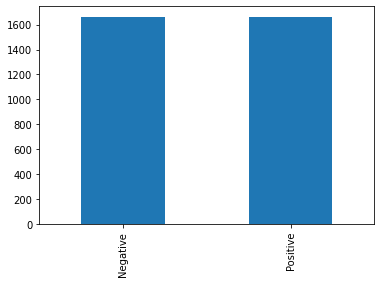

In [5]:
data["label"].replace({0: "Negative", 1: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

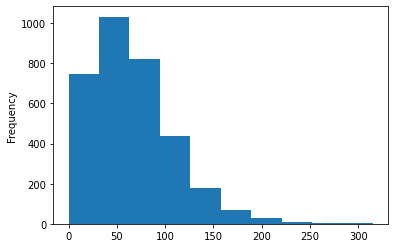

In [6]:
data["text"].str.len().plot.hist()

In [7]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.1, random_state=42, shuffle=True)

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [8]:
from random import randint

random_idx = randint(0, len(X_train))
review_label_mapping = {0: "Negative", 1: "Positive"}
review_label = review_label_mapping[int(y_train.iloc[random_idx])]

print(f"Review {random_idx} contains {len(X_train[random_idx])} words and is {review_label}")
print("Review content:", end="\n\n")
print(" ".join(tokenizer.index_word[idx] for idx in X_train[random_idx]))

Review 2891 contains 6 words and is Positive
Review content:

smale segmentet fremstår dag lexus teknologileder


In [9]:
word_counter = Counter()
for review in X_train:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [10]:
word_counter.most_common(10)

[('litt', 149),
 ('godt', 104),
 ('får', 93),
 ('the', 92),
 ('filmen', 88),
 ('helt', 86),
 ('nok', 85),
 ('gjør', 83),
 ('to', 80),
 ('første', 70)]

In [11]:
maxlen = 100

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [12]:
import numpy as np

y_train = np.array(y_train)
y_test = np.array(y_test)

In [13]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (2993, 100)
X_test shape: (333, 100)


In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(units=128, dropout=0.2, return_sequences=True))
model.add(LSTM(units=128, dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [15]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1563264   
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 128)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,826,561
Trainable params: 1,826,561
Non-trainable params: 0
______________________________________________

In [16]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
150/150 [==============================] - 80s 496ms/step - loss: 0.6841 - accuracy: 0.5535 - val_loss: 0.6831 - val_accuracy: 0.5760
Epoch 2/20
150/150 [==============================] - 48s 321ms/step - loss: 0.4054 - accuracy: 0.8233 - val_loss: 0.6735 - val_accuracy: 0.6444
Epoch 3/20
150/150 [==============================] - 41s 274ms/step - loss: 0.1151 - accuracy: 0.9586 - val_loss: 0.9182 - val_accuracy: 0.6511
Epoch 4/20
150/150 [==============================] - 46s 307ms/step - loss: 0.0384 - accuracy: 0.9871 - val_loss: 1.1095 - val_accuracy: 0.6578
Epoch 5/20
150/150 [==============================] - 51s 342ms/step - loss: 0.0177 - accuracy: 0.9937 - val_loss: 1.2790 - val_accuracy: 0.6194
Epoch 6/20
150/150 [==============================] - 47s 314ms/step - loss: 0.0085 - accuracy: 0.9962 - val_loss: 1.5856 - val_accuracy: 0.6194
Epoch 7/20
150/150 [==============================] - 46s 309ms/step - loss: 0.0041 - accuracy: 0.9983 - val_loss: 1.8247 - val_ac

In [17]:
from datetime import datetime

model.save(f"models/SA-LSTM-BINARY-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

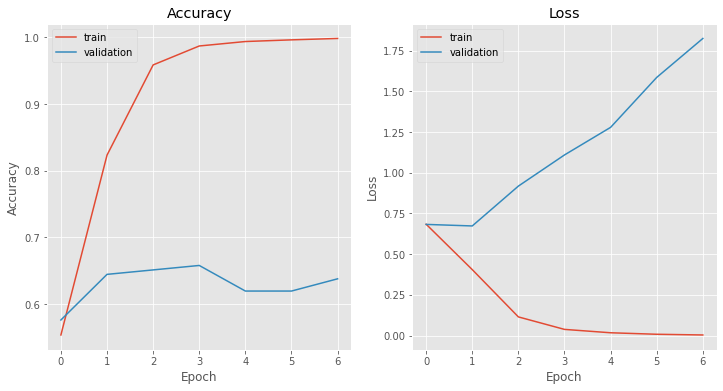

In [18]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [19]:
# Evaluation
val_loss, val_acc = model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

11/11 [==============================] - 2s 169ms/step - loss: 2.1546 - accuracy: 0.6396
Validation loss: 2.1545779705047607
Validation accuracy: 0.6396396160125732
